In [1]:
import tkinter as tk
from tkinter import filedialog, messagebox
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from PIL import UnidentifiedImageError, Image  
import cv2

In [2]:
img_width, img_height = 224, 224
batch_size = 8
data_train_path = r"D:\archive\Vegetable Images\train"  
data_val_path = r"D:\archive\Vegetable Images\validation"  


In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

data_train = train_datagen.flow_from_directory(
    data_train_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='sparse'
)

data_val = val_datagen.flow_from_directory(
    data_val_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='sparse'
)


Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [7]:
base_model = MobileNetV2(input_shape=(img_width, img_height, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(data_train.class_indices), activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filepath='model_checkpoint.weights.h5',  
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)

epochs = 10
history = model.fit(
    data_train,
    epochs=epochs,
    validation_data=data_val,
    callbacks=[checkpoint_callback]
)


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.6262 - loss: 1.2568
Epoch 1: val_loss improved from inf to 0.08727, saving model to model_checkpoint.weights.h5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 426s 227ms/step - accuracy: 0.6263 - loss: 1.2565 - val_accuracy: 0.9827 - val_loss: 0.0873
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.9411 - loss: 0.2177
Epoch 2: val_loss improved from 0.08727 to 0.03847, saving model to model_checkpoint.weights.h5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 365s 194ms/step - accuracy: 0.9411 - loss: 0.2177 - val_accuracy: 0.9900 - val_loss: 0.0385
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9682 - loss: 0.1239
Epoch 3: val_loss improved from 0.03847 to 0.02303, saving model to model_checkpoint.weights.h5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 328s 175ms/step - accuracy: 0.9682 - loss: 0.1239 - val_accuracy: 0.9947 - val_loss: 0.0230
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9740 - 

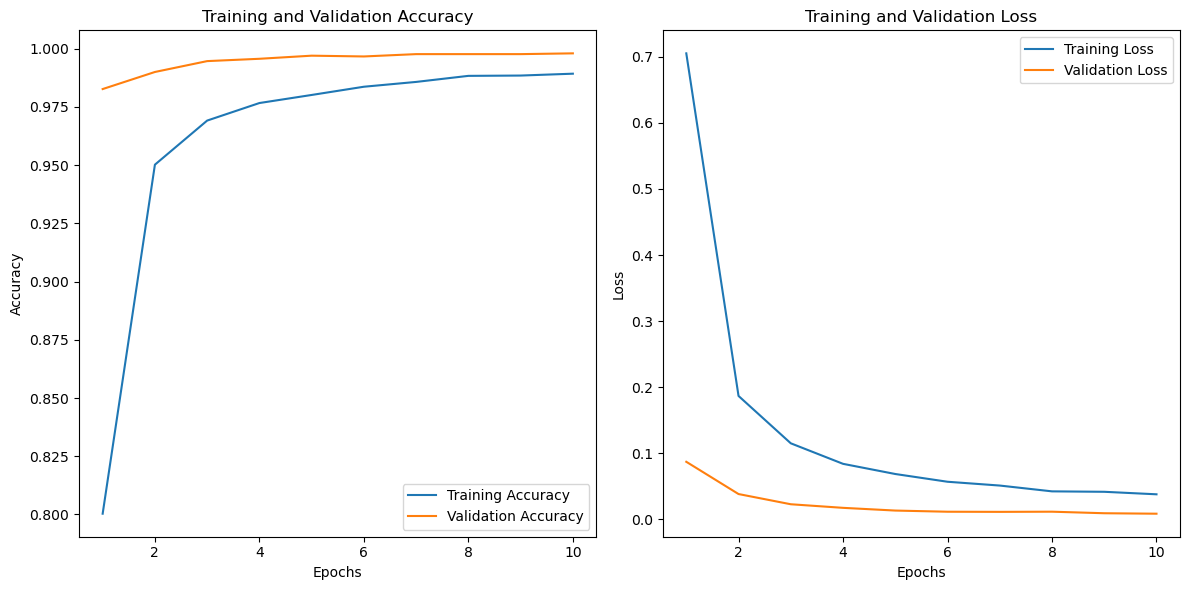

In [14]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='lower right')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)


375/375 ━━━━━━━━━━━━━━━━━━━━ 62s 159ms/step


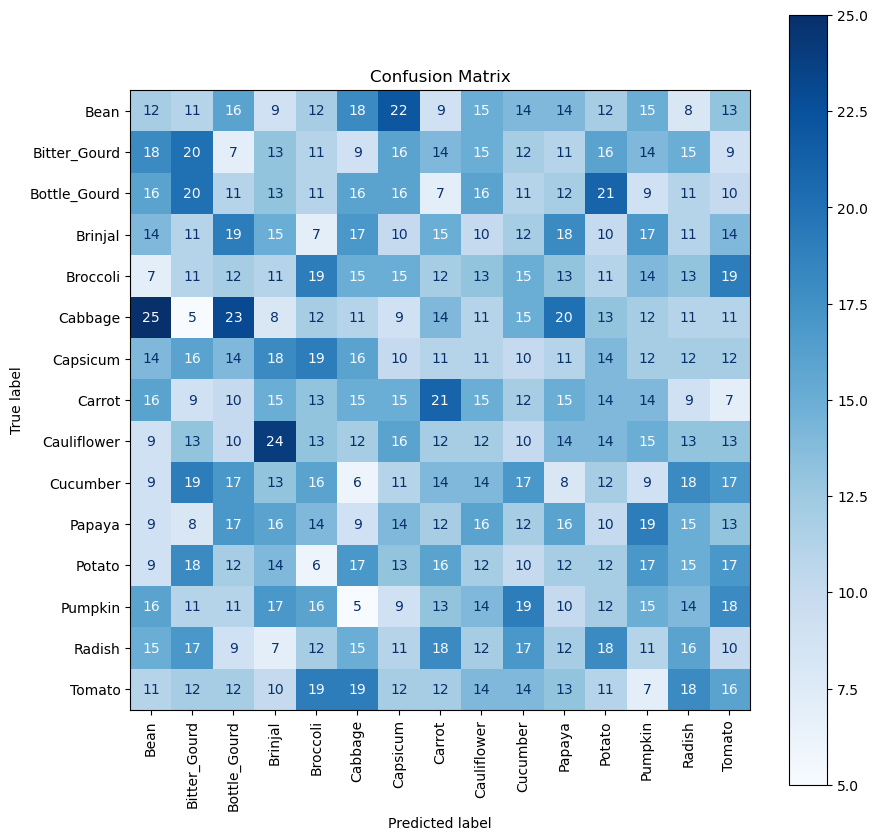

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

val_labels = data_val.classes
val_preds = model.predict(data_val, verbose=1)
val_preds_classes = np.argmax(val_preds, axis=1)

cm = confusion_matrix(val_labels, val_preds_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(data_train.class_indices.keys()))

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()


In [23]:
def load_and_preprocess_image(img, target_size):
    try:
        img = img.resize(target_size)
        img_array = np.array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0
        return img_array
    except UnidentifiedImageError:
        messagebox.showerror("Error", "Cannot identify image file. Please select a valid image.")
        return None
    except Exception as e:
        messagebox.showerror("Error", f"An unexpected error occurred: {e}")
        return None

def predict_image_class(img_array):
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    confidence = np.max(predictions)
    
    class_labels = list(data_train.class_indices.keys())
    
    # Set a confidence threshold, e.g., 0.5
    threshold = 0.5
    if confidence >= threshold:
        messagebox.showinfo("Prediction", f"Predicted Class: {class_labels[predicted_class[0]]}")
    else:
        messagebox.showwarning("Prediction", "Its not Vegetable.")



def upload_and_predict():
    file_path = filedialog.askopenfilename()
    if file_path:
        img = Image.open(file_path)
        img_array = load_and_preprocess_image(img, (img_width, img_height))
        if img_array is not None:
            predict_image_class(img_array)

def capture_and_predict():
    cap = cv2.VideoCapture(0)
    ret, frame = cap.read()
    if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(frame)
        img_array = load_and_preprocess_image(img, (img_width, img_height))
        if img_array is not None:
            predict_image_class(img_array)
        cap.release()
        cv2.destroyAllWindows()
    else:
        messagebox.showerror("Error", "Failed to capture image from camera.")
        cap.release()
        cv2.destroyAllWindows()


In [34]:
root = tk.Tk()
root.title("Image Classifier")
root.geometry("400x200")

upload_button = tk.Button(root, text="Upload and Predict Image", command=upload_and_predict)
upload_button.pack(pady=20)

camera_button = tk.Button(root, text="Capture and Predict Image", command=capture_and_predict)
camera_button.pack(pady=20)

root.mainloop()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
